# Classification d'image vue de face de veaux avec Unet

## Import des dependances

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
import torch
import torch.nn as nn
import torchvision.models.segmentation as segmentation
from torchvision.transforms import v2
from torchvision.io import read_image
import numpy as np
import cv2
import os
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-06-12 13:59:48.566564: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 13:59:49.234721: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Import de la data

Le fichier [face_eda](datasets/face_eda.ipynb) presente une etude de la donnee en generale. 

In [31]:
DATA_FILE = '/data/konrad/datasets/CompleteDatasetNormalFace/Face_annotations.csv'
IMAGE_DIR = "/data/konrad/datasets/CompleteDatasetNormalFace"
df = pd.read_csv(DATA_FILE, index_col=False)
df.head()

image         xmin        ymin  \
0  0-0006905337495862751__6809_ch1_from_280220221...  1224.621468  684.720000   
1  0-2794890219882735__6809_ch1_from_280220221301...  1245.981844  767.943952   
2  0-6056486532338973__6809_ch1_from_280220221410...  1253.091610  703.032775   
3  0-6352214729396954__6809_ch1_from_270220221407...  1126.004987  803.511705   
4  0-7735942344515452__6809_ch1_from_270220221732...  1206.878330  769.152659   

          xmax         ymax     label  
0  1543.636799  1205.307026  Diarrhea  
1  1563.254083  1273.895252  Diarrhea  
2  1526.816613  1186.754230  Diarrhea  
3  1466.383799  1229.435560  Diarrhea  
4  1495.711503  1275.673612  Diarrhea

In [8]:
labels = df.label.unique()
label2id = {l:i for i, l in enumerate(labels)}
id2label = {i:l for i, l in enumerate(labels)}
df['target'] = df.apply(lambda row: label2id[row['label']], axis=1)
# X, y = df['image'].tolist(), df['target'].tolist()

In [33]:
directory_path = IMAGE_DIR
files_list = os.listdir(directory_path)

files = {}
for f in files_list:
    if f.lower().endswith('.jpg') and os.path.isfile(os.path.join(directory_path, f)):
        img_name = f.replace("#", "-")
        img_name = img_name.replace("=", "-")
        img_name = img_name.replace(".", "-")
        img_name = list(img_name)
        img_name[-4] = "_"
        img_name = ''.join(img_name)
        files[img_name] = f

df = pd.merge(df, pd.DataFrame({'image': files.keys(), 'path': files.values(), }), on='image', how='inner')

## Classes et utilitaires

In [2]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=True)


/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /data/konrad/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /data/konrad/.cache/torch/hub/checkpoints/unet-e012d006.pt


In [5]:
model.conv

Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))

### Classes

In [18]:
class CalfFaceDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.data_frame = df
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = self.data_frame.loc[idx, "path"]  
        image = read_image(self.image_dir + '/' + img_name) 
        label = self.data_frame.loc[idx, "target"]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # sample = {'image': image, 'bbox': (xmin, ymin, xmax, ymax), 'label': label}
        image = image.to(device)
        label = torch.tensor(label).to(device)

        sample = {'image': image, 'label': label}
        return sample

class UNetClassifier(nn.Module):
    def __init__(self, num_classes, from_pretrained = True):
        super(UNetClassifier, self).__init__()
        # self.unet = segmentation.deeplabv3_resnet50(pretrained=from_pretrained)  # Load the U-Net backbone
        self.unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=32, pretrained=from_pretrained)

        # Remove the last segmentation layer
        self.unet.conv = nn.Identity()

        self.conv_head = nn.Conv2d(32, num_classes, kernel_size=(1, 1), stride=(1, 1), bias=False)
        # self.conv_head = self.unet.conv
        self.classifier_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global average pooling
            nn.Flatten(),
        )

    def forward(self, x):
        # features = self.unet(x)['out']
        features = self.unet(x)
        features = self.conv_head(features)
        output = self.classifier_head(features)
        return output


# Define the Grad-CAM class
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_grad = None
        self.feature_map = None
        self.forward_hook = None
        self.backward_hook = None

        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.feature_map = output

        def backward_hook(module, grad_in, grad_out):
            self.feature_grad = grad_out[0]

        self.forward_hook = self.target_layer.register_forward_hook(forward_hook)
        self.backward_hook = self.target_layer.register_backward_hook(backward_hook)

    def remove_hooks(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

    def generate_cam(self, image_tensor, target_class):
        self.model.zero_grad()
        output = self.model(image_tensor)
        one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output.to(device))

        weights = torch.mean(self.feature_grad, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.feature_map, dim=1, keepdim=True)
        # cam = weights * self.feature_map
        cam = torch.relu(cam)
        cam = cam.detach().cpu().numpy()
        cam = np.squeeze(cam)
        return cam

### Functions

In [58]:
def get_indices(size, train_ratio = 0.8, test_ratio = 0.1, valid_ratio = 0.1):
    # Split the indices of the dataset
    indices = list(range(size))
    train_indices, temp_indices = train_test_split(indices, test_size=(1 - train_ratio), shuffle=True, random_state=42)
    test_indices, valid_indices = train_test_split(temp_indices, test_size=test_ratio/(test_ratio + valid_ratio), shuffle=True, random_state=42)

    return train_indices, test_indices, valid_indices

# Define a function to generate class activation map
def generate_cam(model, image_tensor, target_class, final_conv_layer):
    model.eval()
    grad_cam = GradCam(model=model, target_layer=final_conv_layer)
    cam = grad_cam.generate_cam(image_tensor, target_class)
    return cam

def display_predicted_cam(model, image, label, transform, id2label, final_conv_layer = None):
    image_tensor = transform(img).to(device).unsqueeze(0)  # Add batch dimension
    
    # Predict the class probabilities
    with torch.no_grad():
        output = model(image_tensor)
    
    # Get the predicted class
    predicted_class = torch.argmax(output).item()
    
    # Generate the CAM for the predicted class
    if not final_conv_layer:
        final_conv_layer = model.unet.backbone.layer4
    cam = generate_cam(model, image_tensor, predicted_class, final_conv_layer)

    # Normalize the CAM
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
    
    # Resize the CAM to match the original image size
    image_tsf = image_tensor[0].cpu()
    
    image_np = np.array(image_tsf.permute(1, 2, 0))
    
    # Overlay the CAM on the original image
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    cam_overlay = cv2.addWeighted(image_np.astype(np.float32), .9, heatmap, 0.5, 0, dtype=cv2.CV_8U)
    
    # Visualize the original image, CAM, and overlay
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title(f'Original Image, Original label: {label}')
    ax[0].axis('off')
    # plt.savefig("original.png") 
    ax[1].imshow(image_tsf.permute(1, 2, 0))
    ax[1].set_title('Input Image')
    # ax[1].axis('off')
    # plt.savefig("input.png") 
    cam_im = ax[2].imshow(cam, cmap='jet')
    ax[2].set_title(f'Class Activation Map (CAM), Predicted label: {id2label[predicted_class]}')
    fig.colorbar(cam_im, ax=ax[2], fraction=0.046, pad=0.04)
    # ax[2].axis('off')
    # ax[3].imshow(cam_overlay)
    # ax[3].set_title(f'CAM Overlay, Predicted label: {id2label[predicted_class]}')
    # ax[3].axis('off')
    plt.show()




def train_model(model, train_loader, valid_loader, scheduler, patience, num_epochs = 10):
    criterion = nn.CrossEntropyLoss()
    best_valid_loss = float('inf')
    early_stopping_counter = 0

        # Initialize lists to store metrics
    train_losses, train_accuracies, train_recalls, train_f1_scores = [], [], [], []
    valid_losses, valid_accuracies, valid_recalls, valid_f1_scores = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        all_preds = []
        all_labels = []
        
        for data in tqdm(train_loader):
            images = data["image"]
            labels = data["label"]
    
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        train_loss /= len(train_loader)
        train_accuracy = accuracy_score(all_labels, all_preds)
        train_recall = recall_score(all_labels, all_preds, average='weighted')
        train_f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append metrics to lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_recalls.append(train_recall)
        train_f1_scores.append(train_f1)
        
        # Validation
        model.eval()
        valid_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for data in valid_loader:
                images = data["image"]
                labels = data["label"]
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item()
                
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        valid_loss /= len(valid_loader)
        valid_accuracy = accuracy_score(all_labels, all_preds)
        valid_recall = recall_score(all_labels, all_preds, average='weighted')
        valid_f1 = f1_score(all_labels, all_preds, average='weighted')

        # Append metrics to lists
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        valid_recalls.append(valid_recall)
        valid_f1_scores.append(valid_f1)
        
        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
        print(f"Valid Loss: {valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}, Recall: {valid_recall:.4f}, F1 Score: {valid_f1:.4f}")
        print("-" * 30)
        # Save the model checkpoint if validation loss is improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stopping_counter += 1

        scheduler.step(valid_loss)
        
        # Early stopping
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

    return (train_losses, train_accuracies, train_recalls, train_f1_scores, valid_losses, valid_accuracies, valid_recalls, valid_f1_scores)

def validate_model(model, test_loader, labels_name):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in test_loader:
            images = data["image"]
            labels = data["label"]
            
            outputs = model(images)
            
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_accuracy = accuracy_score(all_labels, all_preds)
    test_recall_micro = recall_score(all_labels, all_preds, average='micro')
    test_f1_micro = f1_score(all_labels, all_preds, average='micro')
    
    print(f"Test Accuracy: {test_accuracy:.4f}, Micro Recall: {test_recall_micro:.4f}, Micro F1 Score: {test_f1_micro:.4f}")
    
    # Compute metrics per class
    report = classification_report(all_labels, all_preds, target_names=labels_name, output_dict=True)
    
    for class_name, metrics in report.items():
        if class_name not in ('accuracy', 'macro avg', 'weighted avg'):
            print(f"Class: {class_name}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1-score']:.4f}")

def plot_metrics(train_losses, train_accuracies, train_recalls, train_f1_scores, valid_losses, valid_accuracies, valid_recalls, valid_f1_scores):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, valid_losses, label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Plot training and validation accuracies
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Train')
    plt.plot(epochs, valid_accuracies, label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    # Plot training and validation recalls
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_recalls, label='Train')
    plt.plot(epochs, valid_recalls, label='Validation')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()
    
    # Plot training and validation F1 scores
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_f1_scores, label='Train')
    plt.plot(epochs, valid_f1_scores, label='Validation')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

## Entrainement du modele

### Dataset setup

In [15]:
train_indices, test_indices, valid_indices = get_indices(len(df))
IMAGE_SIZE = 256

train_transform = v2.Compose([
    v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = CalfFaceDataset(df.iloc[train_indices, :].reset_index(drop=True), IMAGE_DIR, transform=train_transform)

test_transform = v2.Compose([
    v2.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = CalfFaceDataset(df.iloc[test_indices, :].reset_index(drop=True), IMAGE_DIR, transform=test_transform)
valid_dataset = CalfFaceDataset(df.iloc[valid_indices, :].reset_index(drop=True), IMAGE_DIR, transform=test_transform)

# Data loaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size * 2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size * 2, shuffle=False)


# Accessing a sample from the dataset
# sample = train_dataset[0]
# print(sample)

### Entrainement et validation

In [54]:
model = UNetClassifier(num_classes=len(labels), from_pretrained=False)  # Adjust num_classes according to your dataset
model.to(device)

# Loss and optimizer
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

epochs = 40
patience = 5

train_losses, train_accuracies, train_recalls, train_f1_scores, valid_losses, valid_accuracies, valid_recalls, valid_f1_scores = train_model(model, train_loader, test_loader, scheduler, patience, num_epochs = epochs)

Using cache found in /data/konrad/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.03it/s]


Epoch [1/40]
Train Loss: 1.1065, Accuracy: 0.4564, Recall: 0.4564, F1 Score: 0.3378
Valid Loss: 1.1486, Accuracy: 0.3158, Recall: 0.3158, F1 Score: 0.1516
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.02it/s]


Epoch [2/40]
Train Loss: 1.1039, Accuracy: 0.3893, Recall: 0.3893, F1 Score: 0.3461
Valid Loss: 1.2923, Accuracy: 0.3158, Recall: 0.3158, F1 Score: 0.1516
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.03it/s]


Epoch [3/40]
Train Loss: 1.0682, Accuracy: 0.4631, Recall: 0.4631, F1 Score: 0.2931
Valid Loss: 1.1331, Accuracy: 0.3158, Recall: 0.3158, F1 Score: 0.1516
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.04it/s]


Epoch [4/40]
Train Loss: 1.0712, Accuracy: 0.4631, Recall: 0.4631, F1 Score: 0.2931
Valid Loss: 1.1466, Accuracy: 0.3158, Recall: 0.3158, F1 Score: 0.1516
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.03it/s]


Epoch [5/40]
Train Loss: 1.0980, Accuracy: 0.4631, Recall: 0.4631, F1 Score: 0.2931
Valid Loss: 1.1013, Accuracy: 0.3158, Recall: 0.3158, F1 Score: 0.1516
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.03it/s]


Epoch [6/40]
Train Loss: 1.0918, Accuracy: 0.3758, Recall: 0.3758, F1 Score: 0.2979
Valid Loss: 1.1887, Accuracy: 0.3158, Recall: 0.3158, F1 Score: 0.1516
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.04it/s]


Epoch [7/40]
Train Loss: 1.0695, Accuracy: 0.4631, Recall: 0.4631, F1 Score: 0.2931
Valid Loss: 1.1269, Accuracy: 0.3158, Recall: 0.3158, F1 Score: 0.1516
------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.06it/s]


Epoch [8/40]
Train Loss: 1.0778, Accuracy: 0.4631, Recall: 0.4631, F1 Score: 0.2931
Valid Loss: 1.1570, Accuracy: 0.3158, Recall: 0.3158, F1 Score: 0.1516
------------------------------
Early stopping triggered


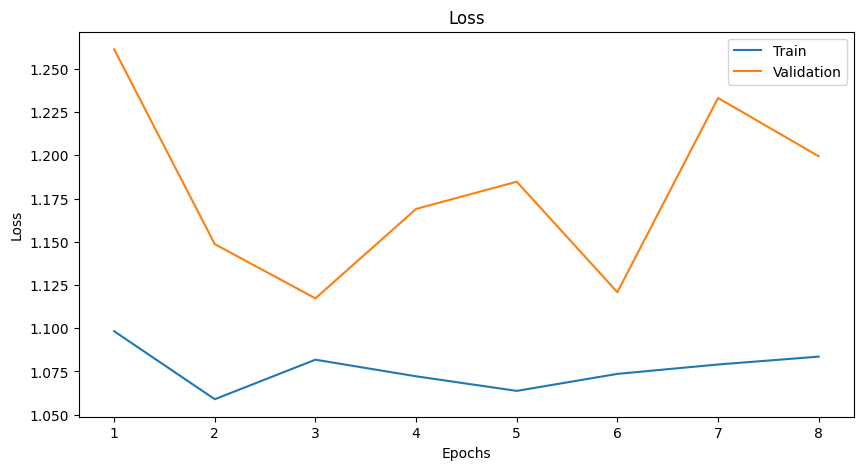

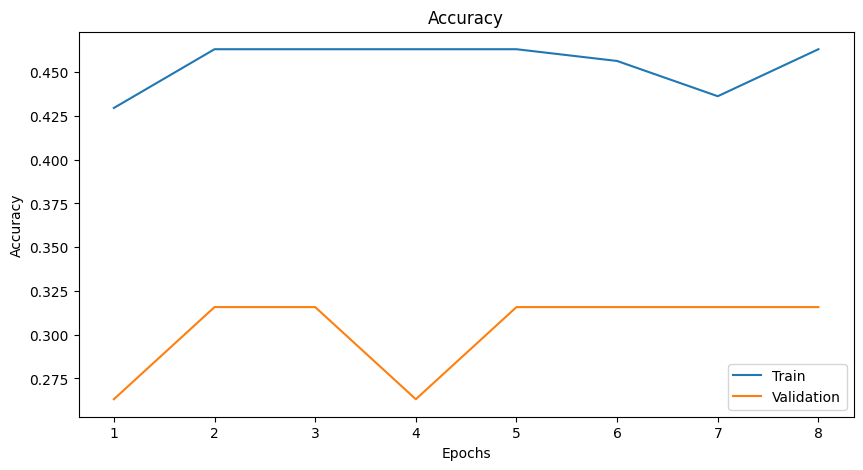

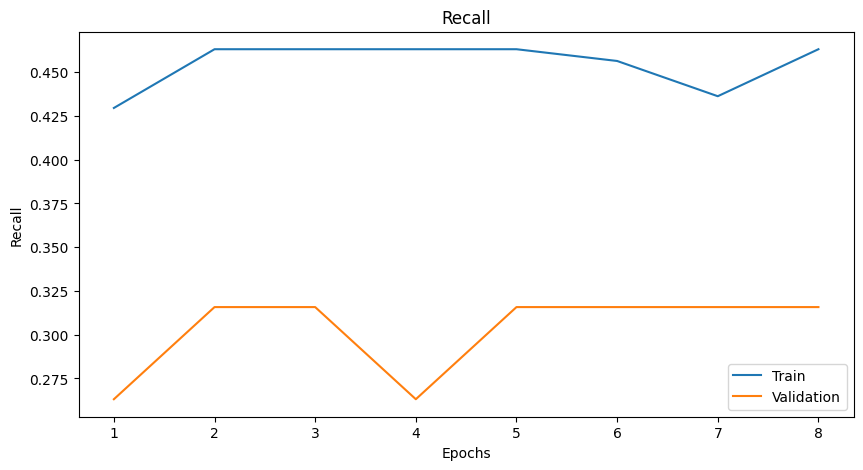

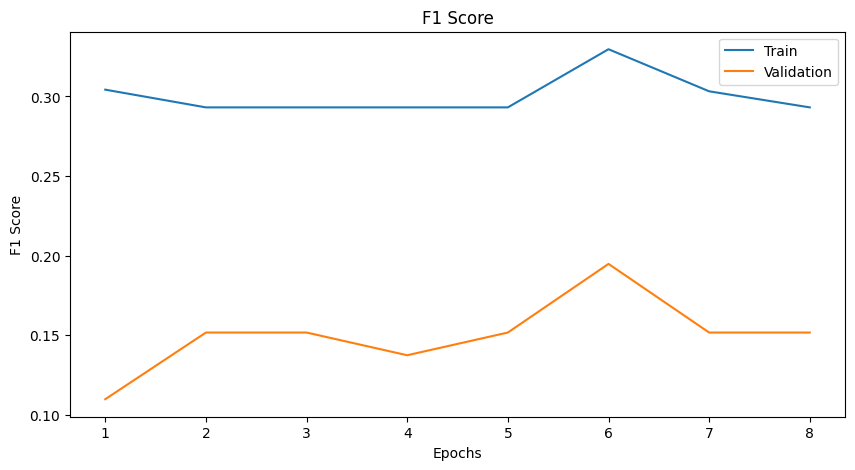

In [50]:
plot_metrics(train_losses, train_accuracies, train_recalls, train_f1_scores,  valid_losses, valid_accuracies, valid_recalls, valid_f1_scores)

In [45]:
validate_model(model, valid_loader, label2id.keys())

Test Accuracy: 0.4211, Micro Recall: 0.4211, Micro F1 Score: 0.4211
Class: Diarrhea, Precision: 0.4211, Recall: 1.0000, F1 Score: 0.5926
Class: Pneumonia, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Class: Healthy, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


/data/konrad/jupiter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/konrad/jupiter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/konrad/jupiter_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


- On peut constater que pour toutes les metrics, il y un ecart entre la courbe d'entrainement et de validation dès la deuxieme epoch et qui s'agrandi plus tard. Le F1-csore sur la validation baisse de l'epoch 3 a 4, ce qui est un signe de surapprentissage.
- Dans plus de 60% des cas, les modeles arrive a bien identifier la classe associe au jeu de donnee a la validation. Cela montre que le modele arrive relativement bien a classer une image vue de face dans une des classes.
- Cependant, il faudrait envisager des techniques de regularisation afin de corriger le surajustement du modele. 

## Interpretation du modele

In [15]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

Nous allons utiliser la methode Grad-cam afin de visualiser l'activation map associe a la classe predite par le model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
(256, 256, 3) (256, 256, 3)


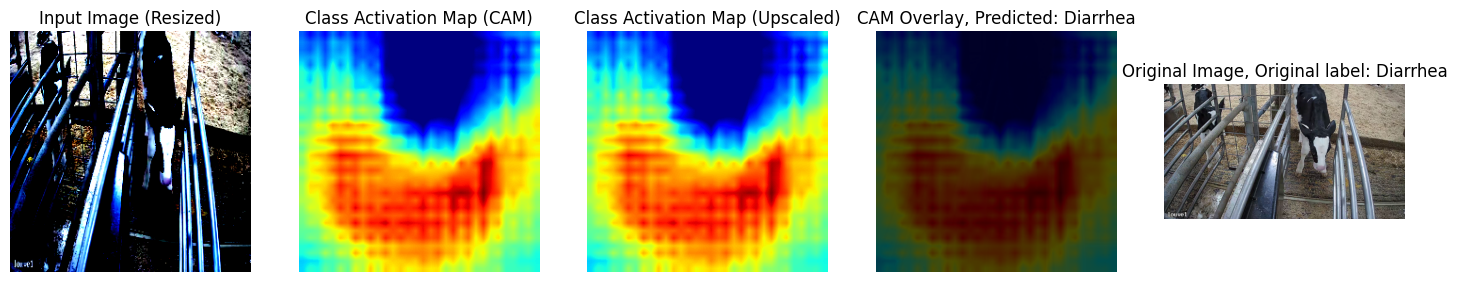

In [119]:
display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
(256, 256, 3) (256, 256, 3)


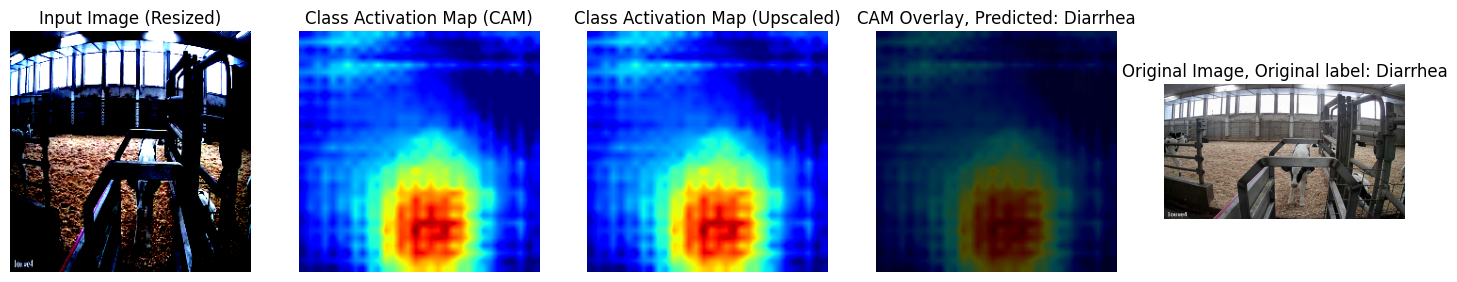

In [122]:
display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])
(256, 256, 3) (256, 256, 3)


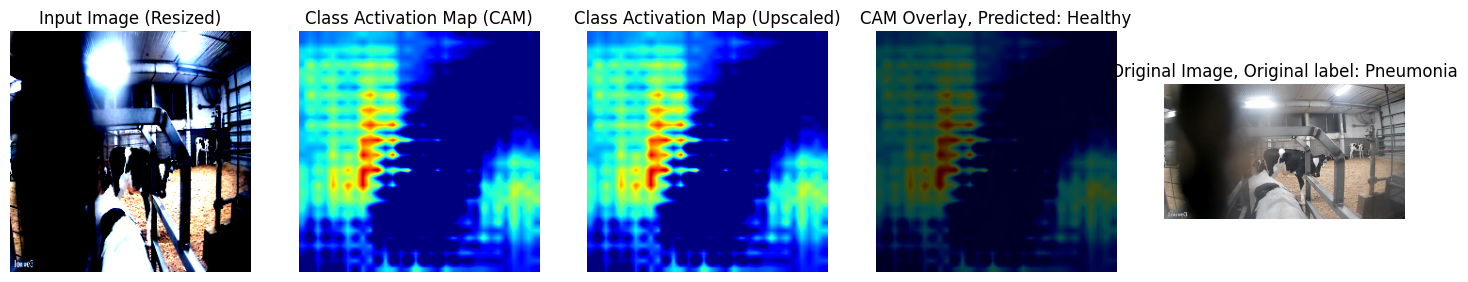

In [125]:
display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


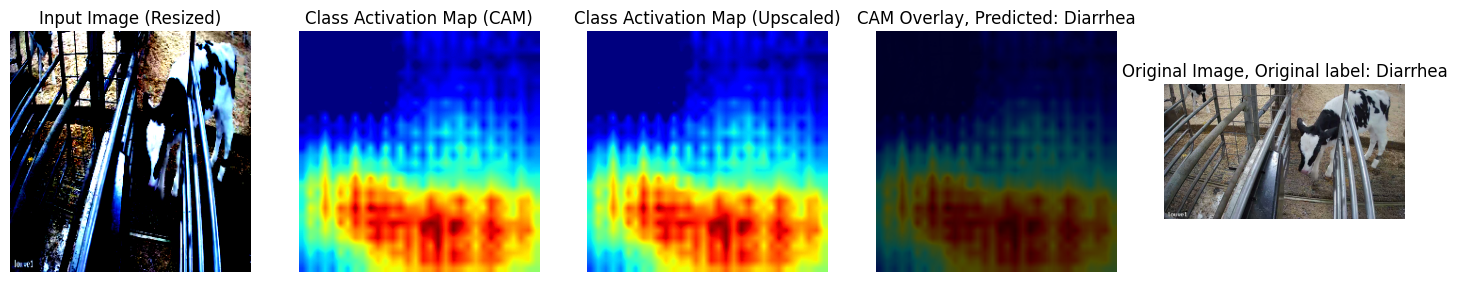

In [11]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


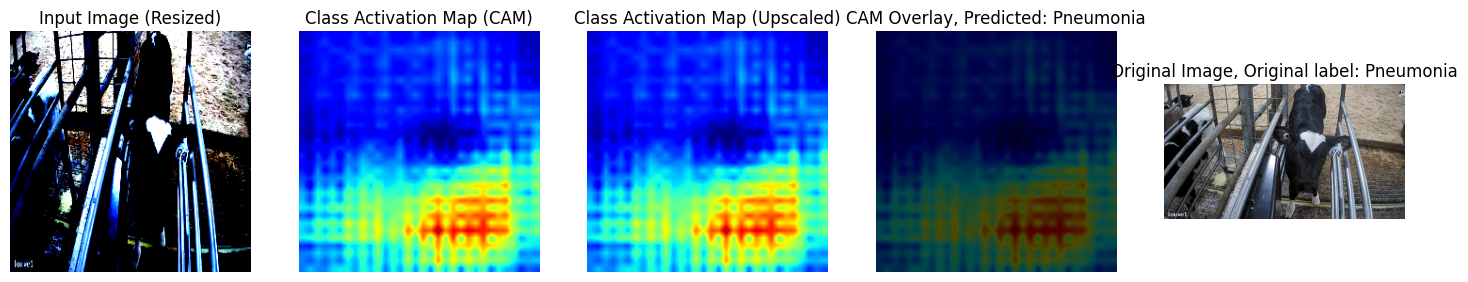

In [12]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


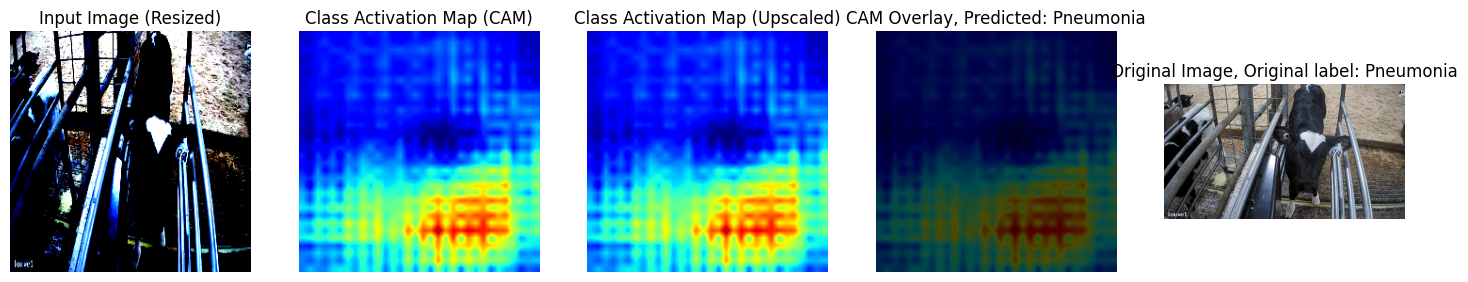

In [13]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


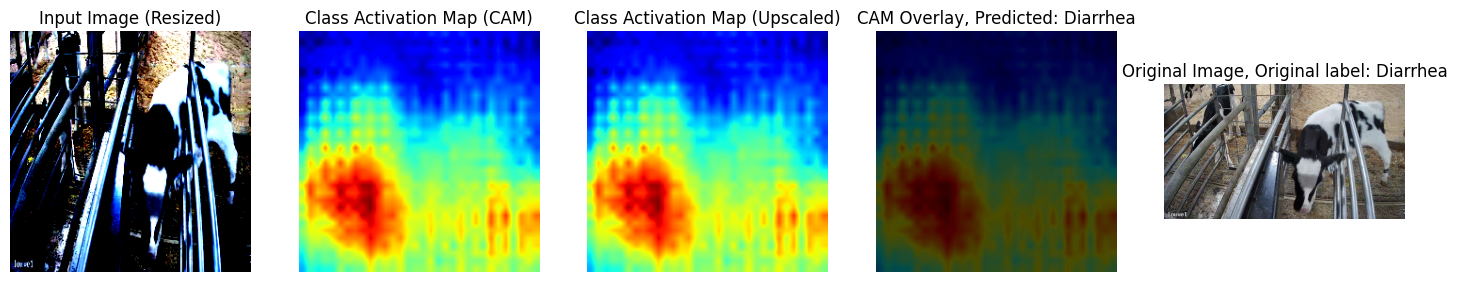

In [14]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


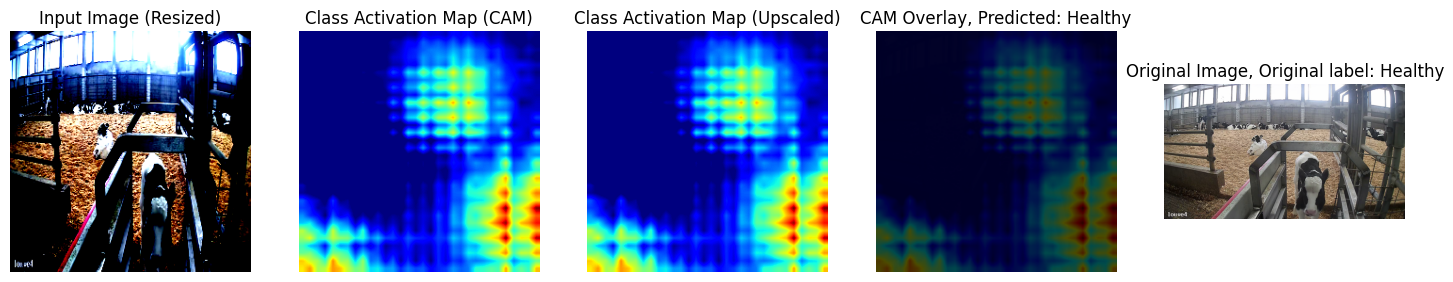

In [15]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


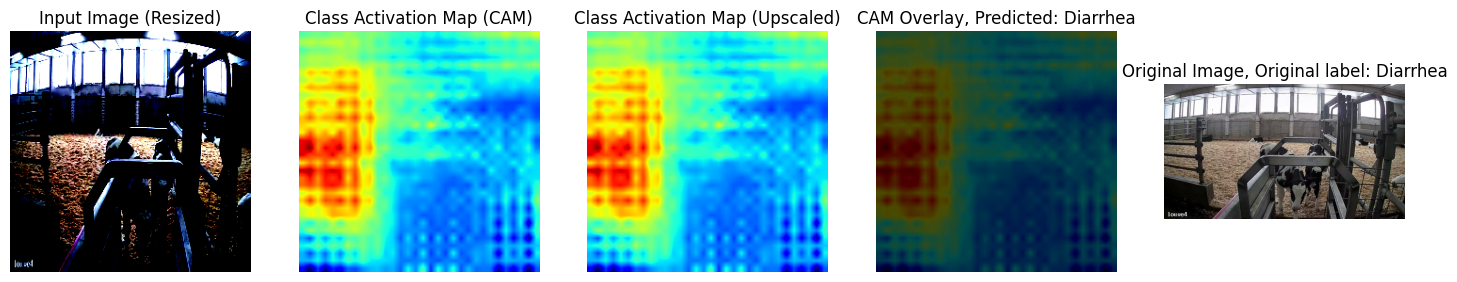

In [16]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

## Interpretations

In [62]:
validate_model(model, valid_loader, label2id.keys())

Test Accuracy: 0.6842, Micro Recall: 0.6842, Micro F1 Score: 0.6842
Class: Diarrhea, Precision: 0.7273, Recall: 1.0000, F1 Score: 0.8421
Class: Pneumonia, Precision: 0.6667, Recall: 0.5714, F1 Score: 0.6154
Class: Healthy, Precision: 0.5000, Recall: 0.2500, F1 Score: 0.3333


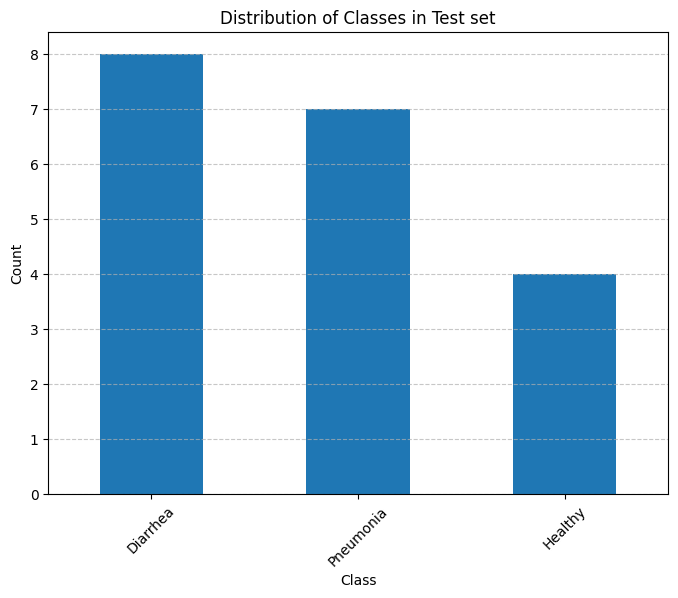

In [65]:
df = valid_loader.dataset.data_frame
class_counts = df['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Classes in Test set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


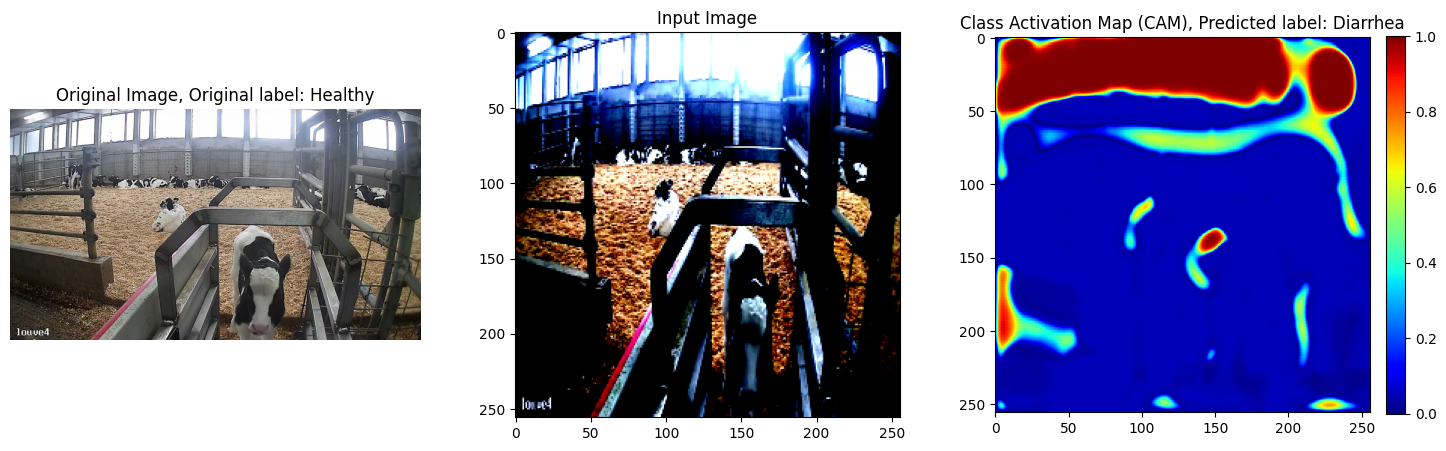

In [59]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


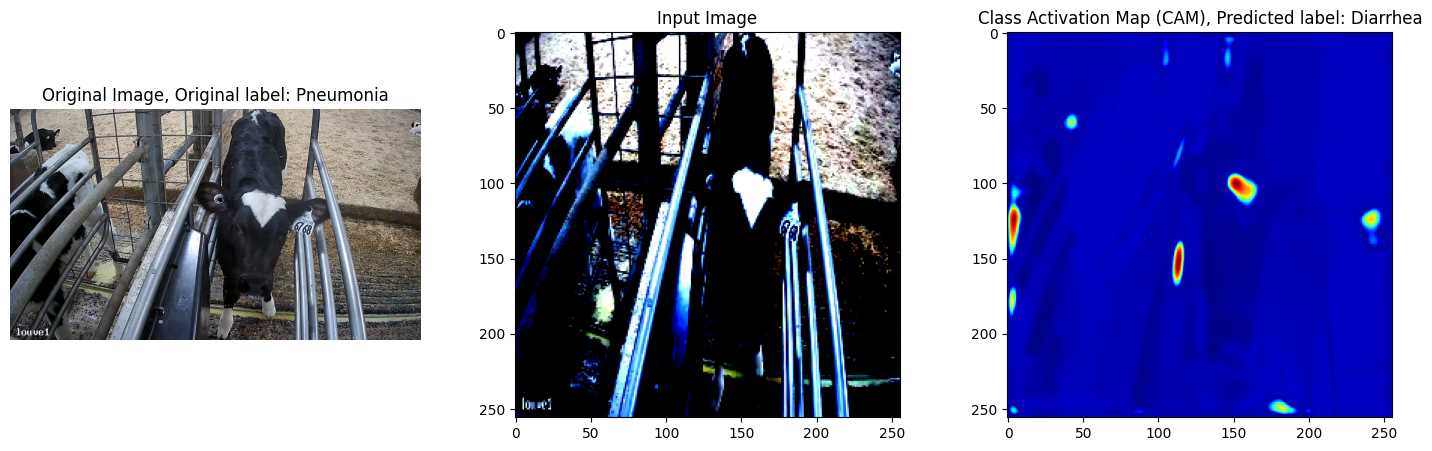

In [56]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


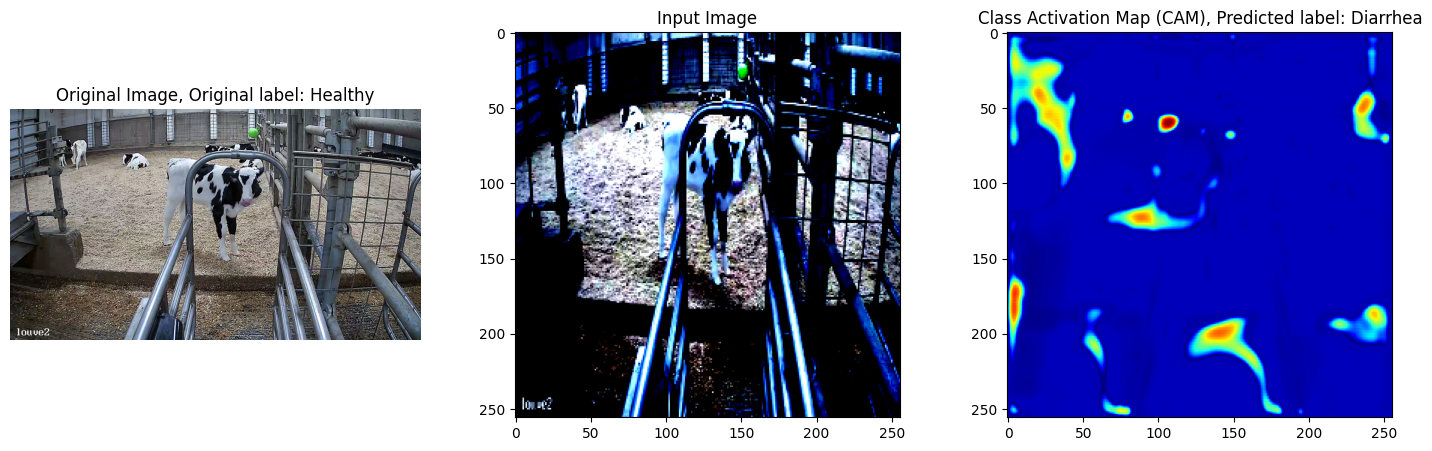

In [57]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

/data/konrad/jupiter_env/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


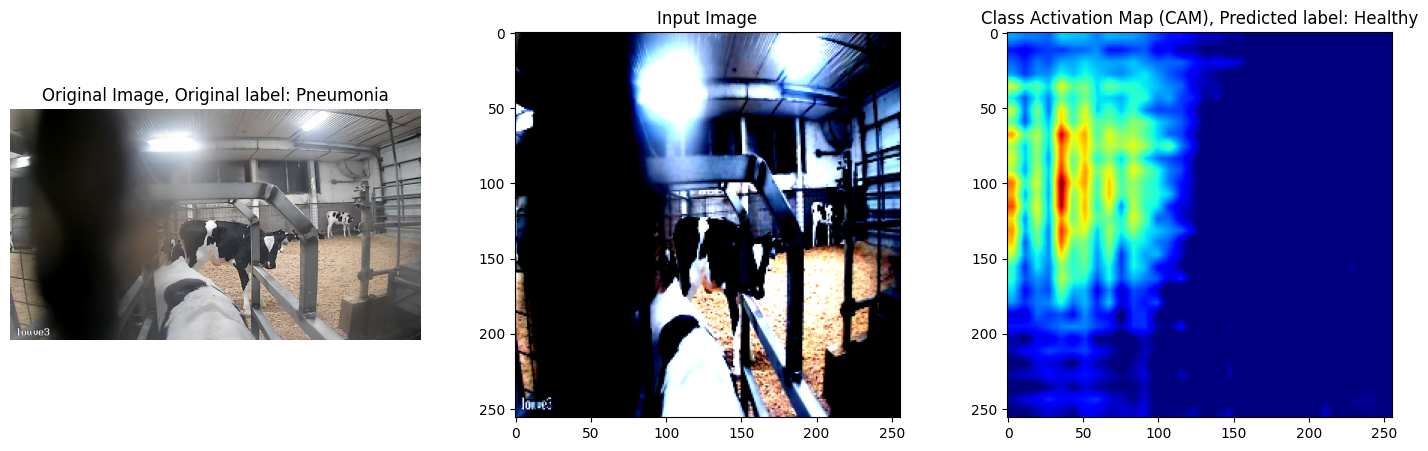

In [56]:
random_item = random.choice(df.iloc[valid_indices, :][["path", "label"]].to_numpy())

img = read_image(f"/data/konrad/datasets/CompleteDatasetNormalFace/{random_item[0]}")
label = random_item[1]

display_predicted_cam(model, img, label, test_transform, id2label, final_conv_layer = model.conv_head)

## Analyses

#### Interpretation des heatmaps

- La zone en rouge dans le heatmap constitue la zone est le plus contribuer a la prediction du modele.
- On remarque que le comportement du modele n'est pas uniforme. Dans le deuxieme exemple, le modele a plus porter l'attention sur le veau dans l'image mais dans le troisieme exemple, elle a plutot decider a partir de la zone illuminé dans l'image.
- Sur le deuxieme exemple, la zone en rouge montre que le modele a porter son attention sur le veau. Mais il manque de precision sur la partie de l'animal. On pourrait conclure que le modele a plutot appris a identifier un veau dans l'image plutot qu'un signe de Diarrhée
- Le heatmap obtenu manque de precision et montre qu'en depit des performances du modeles, ce dernier n'apprends pas encore des caracteristiques interressantes distinguant les classes, comme le ferais un professionel

#### Pistes d'ameliorations

- Sur la donnee d'entrainement, revoir la distribution des classes et des veaux pour s'assurer d'avoir une large representation dans chaque dataset
- Faire un entrainement en utilisant la zone du bbox, centre sur le visage du veau avec une taille fixe: Evaluer la capacite du modele a apprendre des caracteristiques visuels de chaque classe presents dans l'images
- Reduire la complexite du modele (ou encore partir d'un modele sans pre-entrainement), pour palier au probleme de surajustement, et essayer d'autres methodes de regularisation, dont d'autres methodes de data augmentation
- Presenter les metrics par classes, en plus des valeurs globales, et modifier le calcul des metriqies globales (passer au macro)
- 

#### Conclusion 
- La taille reduite de la dataset est un frein a la capacite de generalisation du modele, et aussi a sa capacite a apprendre des caracteristiques visuels proches de celui utilises par des professionnels pour decider de l'etat d'un veau.
- Le methode d'interpretation du comportement du veau utilise le Grad-cam, une methode post-hoc et exploite l'architecture readapte du modele Unet en se basant sur la derniere activation map associe a la classe predite. Elle part du principe d'amener le modele a determiner dans chaque image, des caracteristiques distinguant chaque classe visualisable via la classe activation map.
- L'approche d'interpretation part du principe qu'un signal (detectable par un professionnel) permettant de distinguer chaque classe se trouve dans l'image. Par contre, on peut constater que le modele peut se baser sur d'autres caracteristiques (comme la presence d'un veau, sa couleur, ou son emplacement) pour faire une prediction. L'approche fine-grained, est donc une piste importante a exploiter. 